# Import Required Libraries
Import necessary libraries, including TensorFlow, Keras, NumPy, Pandas, and others.

In [3]:

import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, Embedding, LSTM, Bidirectional, concatenate, 
                                     RandomFlip, RandomRotation, Rescaling, Conv2D, GlobalAveragePooling2D, TextVectorization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import re
import string
import gc


# Load and Inspect Data
Load the dataset and inspect the first few rows to understand its structure.

In [5]:
df = pd.read_csv("../Tensorquest/memotion_dataset_7k/labels.csv")
df.head()
print(df['humour'].unique())
print(df['sarcasm'].unique())
print(df['offensive'].unique())
print(df['motivational'].unique())
print(df['overall_sentiment'].unique())

['hilarious' 'not_funny' 'very_funny' 'funny']
['general' 'not_sarcastic' 'twisted_meaning' 'very_twisted']
['not_offensive' 'very_offensive' 'slight' 'hateful_offensive']
['not_motivational' 'motivational']
['very_positive' 'positive' 'neutral' 'negative' 'very_negative']


In [6]:
df = pd.read_csv("../Tensorquest/memotion_dataset_7k/labels.csv")
df.head()

df.dropna(inplace=True)
df = df.replace({
    'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious': 3},
    'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 2, 'very_twisted': 3},
    'offensive': {'not_offensive': 0, 'slight': 1, 'very_offensive': 2 , 'hateful_offensive':3},
    'motivational': {'not_motivational': 0, 'motivational': 1},
    'overall_sentiment': {'very_negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very_positive': 4}

    
})

print(df[['humour', 'sarcasm', 'offensive', 'motivational']].dtypes)
print(df[['humour', 'sarcasm', 'offensive', 'motivational']].head())

C:\Users\shubh\AppData\Local\Temp\ipykernel_17924\2069428415.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({


humour          int64
sarcasm         int64
offensive       int64
motivational    int64
dtype: object
   humour  sarcasm  offensive  motivational
0       3        1          0             0
1       0        1          0             1
2       2        0          0             0
3       2        2          2             1
4       3        3          2             0


In [7]:
df.head()

,Unnamed: 0,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,3,1,0,0,4
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,0,1,0,1,4
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,2,0,0,0,3
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,2,2,2,1,3
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,3,3,2,0,2


# Handle Missing Values
Check for missing values and drop or fill them as necessary.

In [9]:
missing_values = df.isnull().sum()
print("Missing values for each column is ,\n ", missing_values)

Missing values for each column is ,
  Unnamed: 0           0
image_name           0
text_ocr             0
text_corrected       0
humour               0
sarcasm              0
offensive            0
motivational         0
overall_sentiment    0
dtype: int64


# Image Preprocessing
Load images, resize them, and normalize pixel values.

In [11]:
width, height = 100, 100
X = []
for i in range(df.shape[0]):
    try:
        path = '../Tensorquest/memotion_dataset_7k/images/' + df.iloc[i]['image_name']
        img = image.load_img(path, target_size=(width, height, 3) )
        img = image.img_to_array(img) / 255.0
        X.append(img)
    except (FileNotFoundError, OSError):
        continue
X = np.array(X)

C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Preparing target variables  

In [13]:

Y = df[['humour', 'sarcasm', 'offensive', 'motivational']].iloc[:len(X)]

In [14]:
# --- 5. Standardize Text ---
def standardize_text(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data
df['text_corrected'] = standardize_text(df['text_corrected'].astype(str)).iloc[:len(X)]

In [15]:
# --- 6. Split Dataset (images, text, targets together to avoid misalignment) ---
X_train, X_test, y_train, y_test, X_text_train, X_text_test = train_test_split(
    X, Y, df['text_corrected'].values, test_size=0.2, random_state=30)

y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

In [16]:
# --- 7. Text Vectorization ---
vocab_size = 100000
sequence_length = 50
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length,
    standardize="lower_and_strip_punctuation"
)
vectorize_layer.adapt(df['text_corrected'].values)
X_text_train = vectorize_layer(X_text_train)
X_text_test = vectorize_layer(X_text_test)


In [17]:
vocab = vectorize_layer.get_vocabulary()
import pickle
with open("vectorizer_vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

In [18]:
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')
X_text_train = np.array(X_text_train).astype('int32')
X_text_test = np.array(X_text_test).astype('int32')
y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

In [19]:

# --- 8. Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2)
])

# what this does is randomly flips the models and randomly roatets the images so as to prevent overfitting , it is roattwed by 20% meaning 72 degrees


In [20]:
# --- 9. Build Base Image Model ---
base_model_1 = tf.keras.applications.ResNet50(input_shape=(100, 100, 3), include_top=False, weights='imagenet')
base_model_2 = tf.keras.applications.VGG16(input_shape=(100, 100, 3), include_top=False, weights='imagenet')
base_model_1.trainable = False
base_model_2.trainable = False

image_input = Input(shape=(100, 100, 3), name='image_input')
x = data_augmentation(image_input)
x = tf.keras.applications.resnet50.preprocess_input(x)
x1 = base_model_1(x, training=False)
x2 = base_model_2(x, training=False)
x1 = Conv2D(2048, kernel_size=2, padding='valid')(x1)
x1 = Dense(512)(x1)
x2 = Dense(512)(x2)
x = concatenate([x1, x2])
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2, name='dropout_layer')(x)
image_model = Model(inputs=image_input, outputs=x)

In [21]:
# --- 10. Build Text Model ---
text_input = Input(shape=(sequence_length,), dtype=tf.int32, name='text')
embedding_dim = 32
y = Embedding(vocab_size, embedding_dim, name="embedding")(text_input)
y = Dropout(0.5)(y)
y = Bidirectional(LSTM(256, activation='relu', return_sequences=True))(y)
y = Bidirectional(LSTM(128, activation='relu'))(y)
y = Dense(1024, activation='relu')(y)
y = Dropout(0.5)(y)
text_model = Model(inputs=text_input, outputs=y)

In [22]:
# --- 11. Combine Models ---
combined = concatenate([image_model.output, text_model.output])
combined = Dense(512, activation='relu')(combined)
combined = Dropout(0.5)(combined)
output = Dense(4, activation='linear', name="semantic_output")(combined)
combined_model = Model(inputs=[image_model.input, text_model.input], outputs=output)
combined_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [23]:
print(type(X_train), X_train.dtype)
print(type(X_text_train), X_text_train.dtype)
print(type(y_train), y_train.dtype)

<class 'numpy.ndarray'> float32
<class 'numpy.ndarray'> int32
<class 'numpy.ndarray'> float32


In [24]:
# --- 12. Train Model ---
gc.collect()
tf.keras.backend.clear_session()
history = combined_model.fit(
    {'image_input': X_train, 'text': X_text_train},
    y_train,
    validation_data=({'image_input': X_test, 'text': X_text_test}, y_test),
    epochs=5,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)
    ]
)



Epoch 1/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 692s 2s/step - loss: 16.5468 - mae: 2.0139 - val_loss: 0.6778 - val_mae: 0.6527 - learning_rate: 0.0010
Epoch 2/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - loss: 0.8098 - mae: 0.7109 - val_loss: 0.6515 - val_mae: 0.6284 - learning_rate: 0.0010
Epoch 3/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 618s 2s/step - loss: 0.7808 - mae: 0.6990 - val_loss: 0.6384 - val_mae: 0.6240 - learning_rate: 0.0010
Epoch 4/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - loss: 0.7570 - mae: 0.6943 - val_loss: 0.6132 - val_mae: 0.6371 - learning_rate: 0.0010
Epoch 5/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - loss: 18022.4434 - mae: 17.8966 - val_loss: 1.0771 - val_mae: 0.7934 - learning_rate: 0.0010


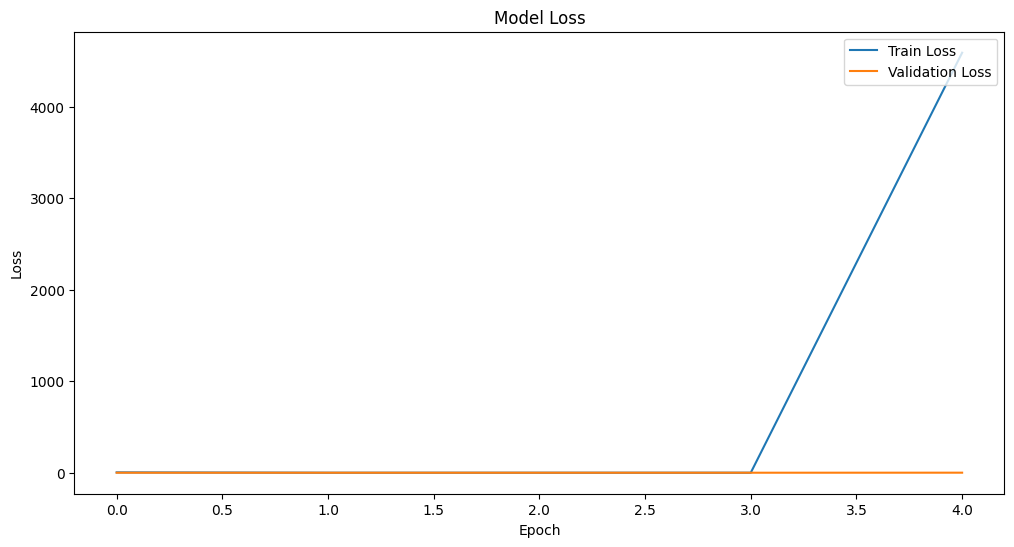

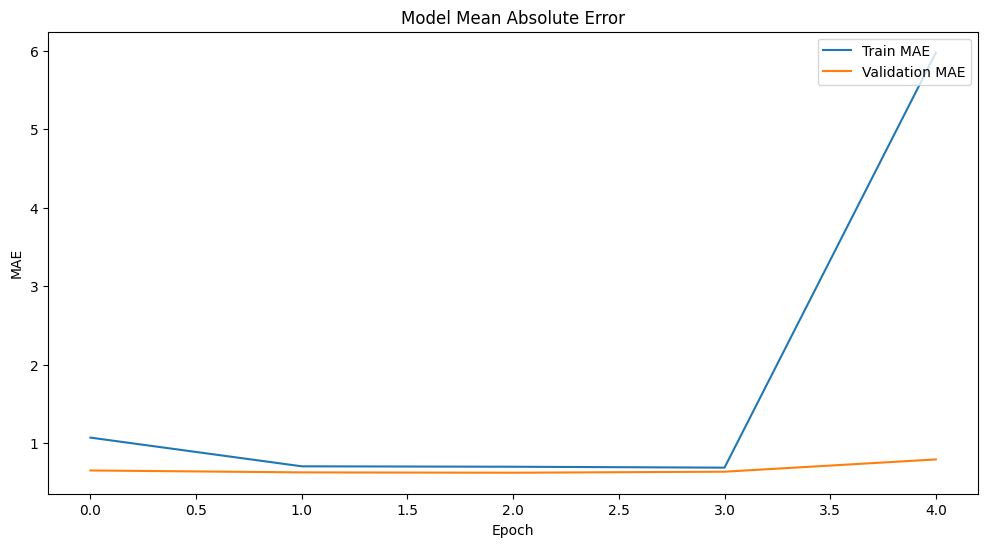

In [25]:
# --- 13. Plot Training History ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.show()


In [26]:
# --- 14. Evaluate Model ---
combined_predictions = combined_model.predict({'image_input': X_test, 'text': X_text_test})
mae_humor_combined = mean_absolute_error(y_test[:, 0], combined_predictions[:, 0])
mae_sarcasm_combined = mean_absolute_error(y_test[:, 1], combined_predictions[:, 1])
mae_offense_combined = mean_absolute_error(y_test[:, 2], combined_predictions[:, 2])
mae_motivation_combined = mean_absolute_error(y_test[:, 3], combined_predictions[:, 3])
print(f"MAE for Humor (Combined): {mae_humor_combined}")
print(f"MAE for Sarcasm (Combined): {mae_sarcasm_combined}")
print(f"MAE for Offense (Combined): {mae_offense_combined}")
print(f"MAE for Motivation (Combined): {mae_motivation_combined}")


43/43 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step 
MAE for Humor (Combined): 0.7812963128089905
MAE for Sarcasm (Combined): 0.5826717019081116
MAE for Offense (Combined): 0.7195883393287659
MAE for Motivation (Combined): 0.46471327543258667


Classification Report for Humour:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       326
         1.0       0.34      1.00      0.51       471
         2.0       0.00      0.00      0.00       444
         3.0       0.00      0.00      0.00       125

    accuracy                           0.34      1366
   macro avg       0.09      0.25      0.13      1366
weighted avg       0.12      0.34      0.18      1366



C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


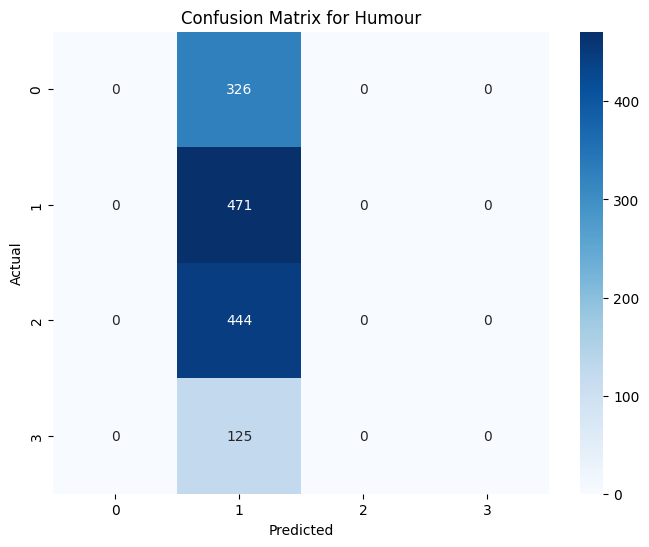

Classification Report for Sarcasm:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       317
         1.0       0.51      1.00      0.68       696
         2.0       0.00      0.00      0.00       283
         3.0       0.00      0.00      0.00        70

    accuracy                           0.51      1366
   macro avg       0.13      0.25      0.17      1366
weighted avg       0.26      0.51      0.34      1366



C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


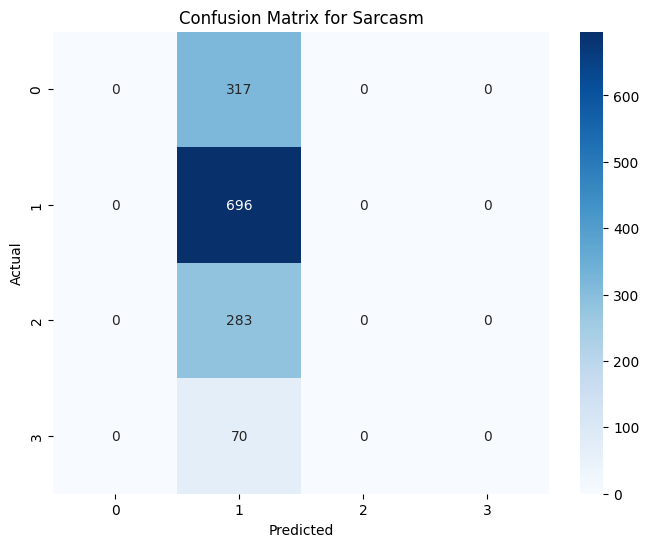

Classification Report for Offensive:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       556
         1.0       0.35      1.00      0.52       475
         2.0       0.00      0.00      0.00       297
         3.0       0.00      0.00      0.00        38

    accuracy                           0.35      1366
   macro avg       0.09      0.25      0.13      1366
weighted avg       0.12      0.35      0.18      1366



C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


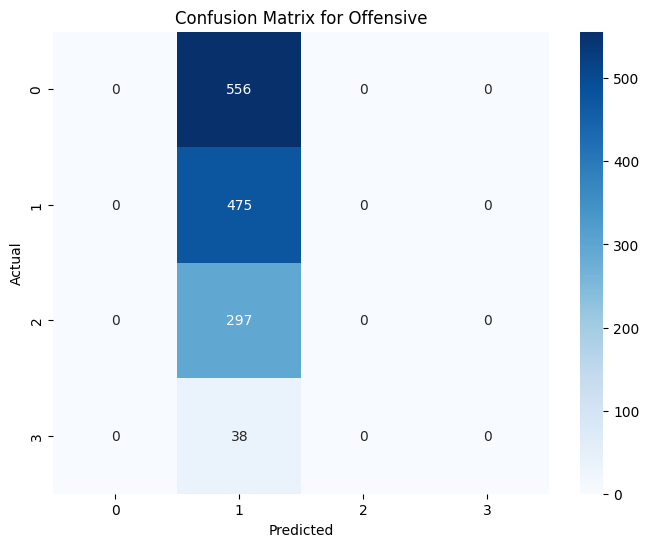

Classification Report for Motivational:
              precision    recall  f1-score   support

         0.0       0.66      1.00      0.79       897
         1.0       0.00      0.00      0.00       469

    accuracy                           0.66      1366
   macro avg       0.33      0.50      0.40      1366
weighted avg       0.43      0.66      0.52      1366



C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shubh\anaconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


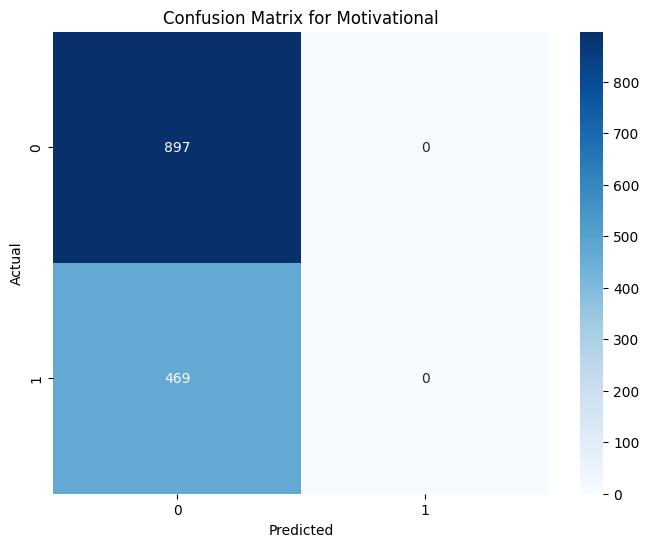

In [27]:

# Classification reports and confusion matrices
for i, label in enumerate(['humour', 'sarcasm', 'offensive', 'motivational']):
    print(f"Classification Report for {label.capitalize()}:")
    print(classification_report(y_test[:, i], np.round(combined_predictions[:, i])))
    conf_matrix = confusion_matrix(y_test[:, i], np.round(combined_predictions[:, i]))
    # ... plotting code ...
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label.capitalize()}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()